In [1]:
import sys
sys.path.append('../')

In [2]:
from IPython.display import display, HTML
from tft.data import DataLoader
from tft.config import read_config
import pandas as pd

In [3]:
cfg = read_config('../../config.yaml')

In [4]:
dt = DataLoader(data_dir=cfg.scrape.data_dir).load_all(set_name='TFTSet7_2', days_cutoff=7)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.77s/it]


In [5]:
players_count = dt.participants.index.unique(1).size
matches_count = dt.participants.index.unique(0).size
HTML(f"Unique players {players_count} in {matches_count} matches")

In [6]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [7]:
def winrate(x):
    return x.where(x == True).count() / x.count()

def true_count(x):
    return x.where(x == True).count()

def total_perc(total):
    return lambda x: x.count() / total

def winrate_for(df, group: str, cutoff = 1, perc_cutoff = 0.01):
    df['winrate'] = df['placement'] <= cutoff
    df['win'] = df['placement'] <= cutoff
    df['loss'] = df['placement'] >= cutoff
    df['total_perc'] = 1
    cnt = len(df)
    wr = df.groupby(group).agg({
        'winrate': winrate,
        'win': true_count, 'loss': true_count,
        'total_perc': total_perc(cnt),
    })
    return wr[wr['total_perc'] > perc_cutoff].sort_values(by=['winrate'], ascending=False)
    

In [8]:
player_winrate = winrate_for(dt.participants, 'puuid', perc_cutoff = 0.00001)

In [9]:
mn = player_winrate['winrate'].mean()
HTML(f"Mean player winrate <strong>{round(mn * 100, 2)}%</strong>")

<AxesSubplot:xlabel='character_id'>

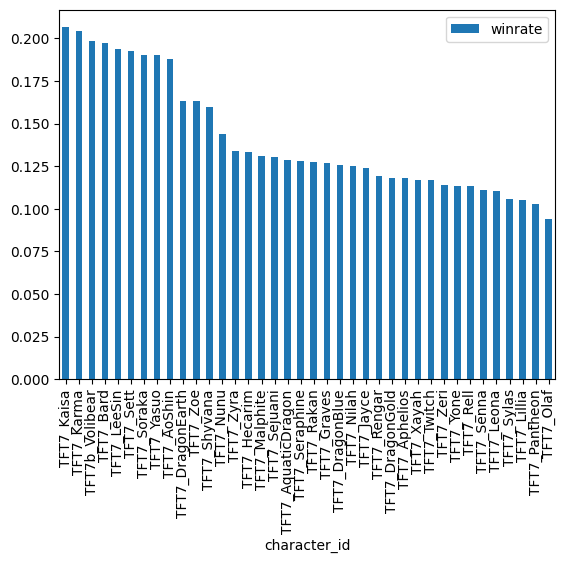

In [10]:
winrate_for(dt.units, 'character_id')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='trait'>

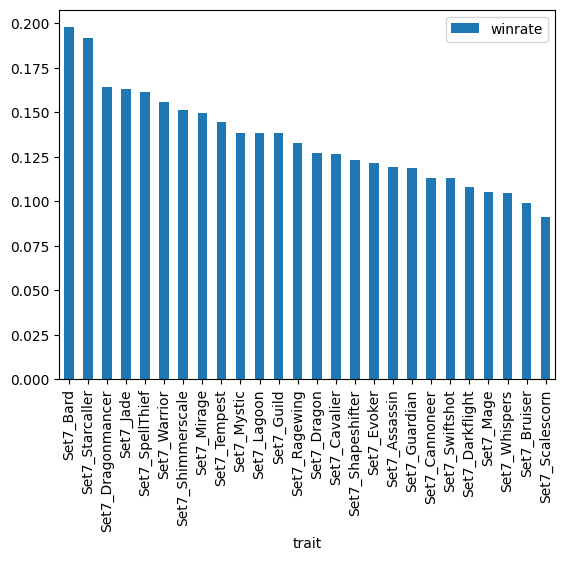

In [11]:
winrate_for(dt.traits, 'trait')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='item'>

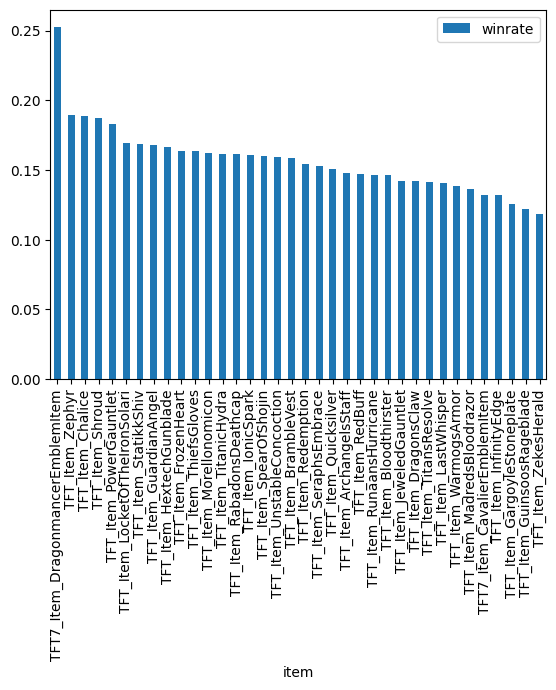

In [12]:
winrate_for(dt.items, 'item')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='augment'>

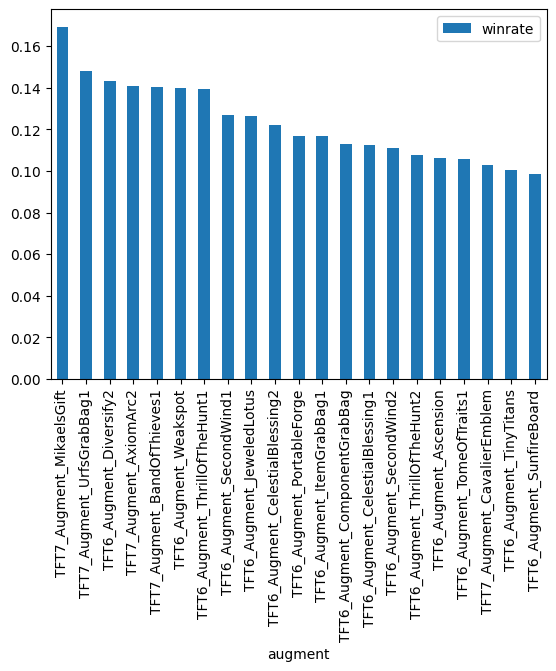

In [13]:
winrate_for(dt.augments, 'augment')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='character_id'>

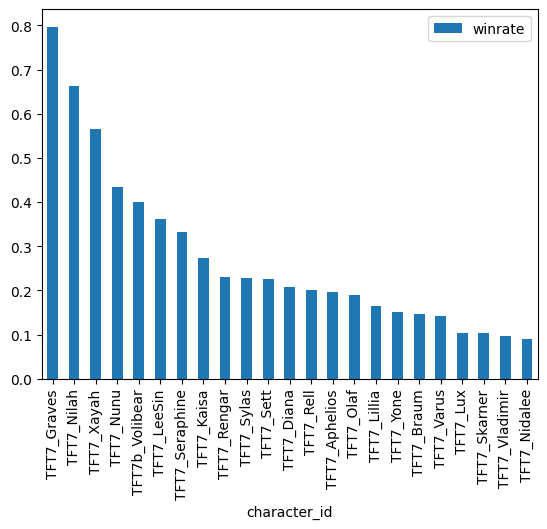

In [14]:
star3_df = dt.units.loc[:][dt.units['tier'] == 3]
winrate_for(star3_df, 'character_id')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='character_id,item'>

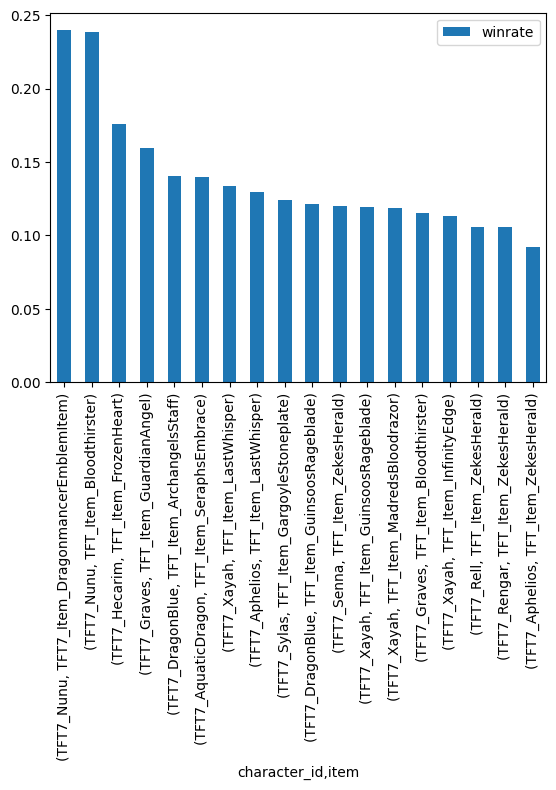

In [15]:
winrate_for(dt.items, ['character_id', 'item'], perc_cutoff = 0.005)[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='character_id,trait'>

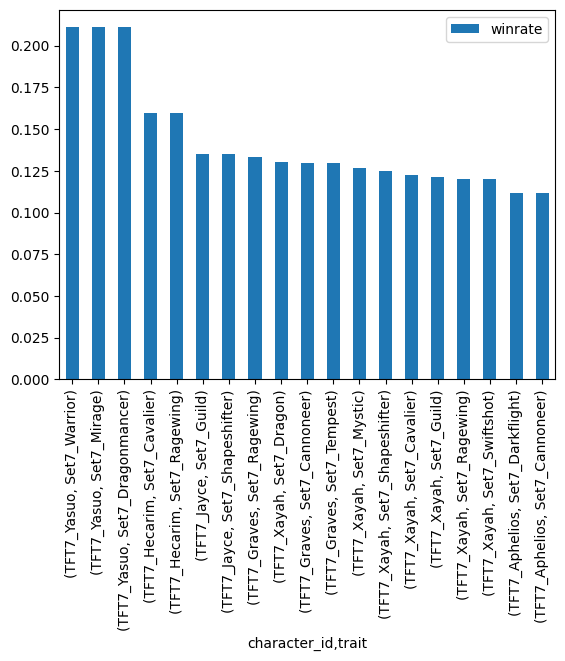

In [16]:
winrate_for(dt.items.merge(dt.traits), ['character_id', 'trait'], perc_cutoff = 0.005)[['winrate']].plot(kind='bar')

In [17]:
def top_trait(x):
    return x

top_trait_placement = dt.traits[['trait', 'num_units', 'placement']].groupby(['match_id', 'puuid']).max().reset_index()

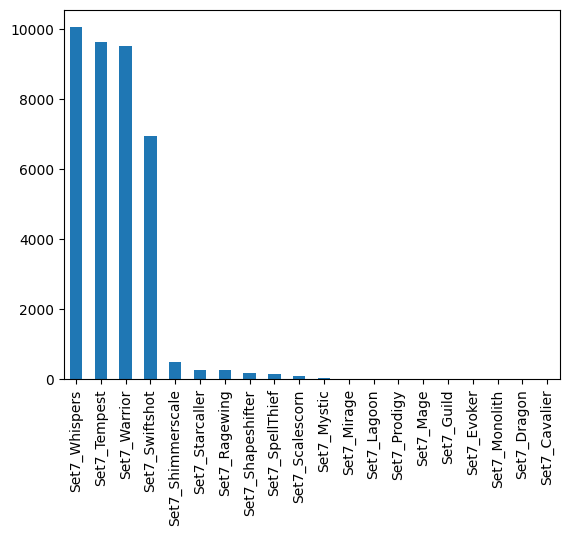

In [18]:
trait_popularity = top_trait_placement['trait'].value_counts()
plot = trait_popularity.plot(kind='bar')
HTML(f"Trait popularity {plot}")

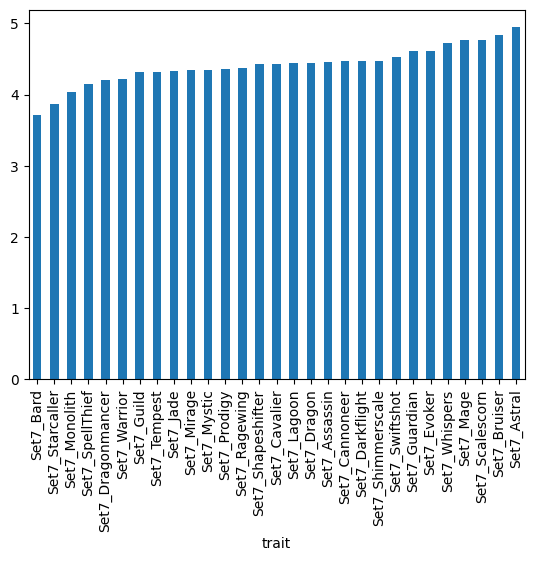

In [19]:
trait_avg_placement_raw = dt.traits[['trait', 'placement']].groupby('trait').mean('placement')['placement'].sort_values(ascending=True)
plot = trait_avg_placement_raw.plot(kind='bar')

HTML(f"Avg trait placement (unadjusted for its tier): {plot}")

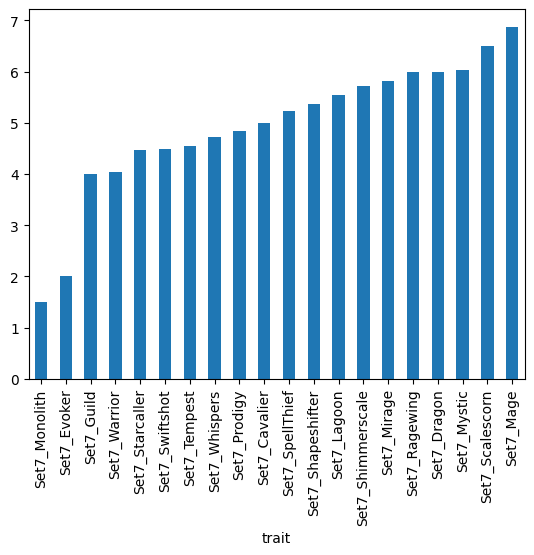

In [20]:
trait_avg_placement = top_trait_placement.groupby('trait').mean('placement')['placement'].sort_values(ascending=True)
plot = trait_avg_placement.plot(kind='bar')

HTML(f"Avg trait placement: {plot}")

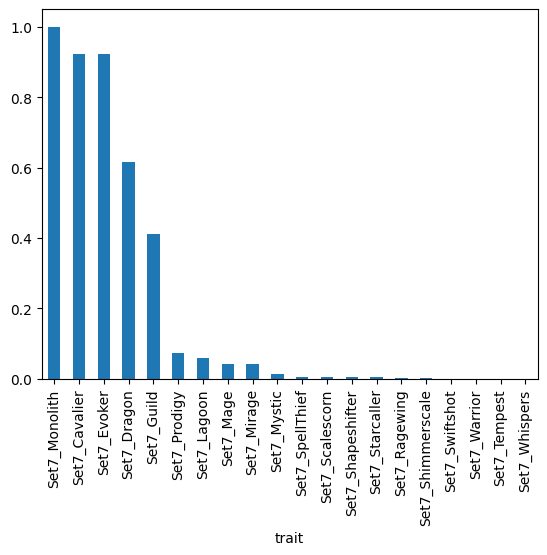

In [21]:
t_avg_placement_df = trait_avg_placement.to_frame('trait_avg_placement')
t_popularity_df = trait_popularity.to_frame('trait_popularity')

#t_avg_placement_df['adjusted_placement'] = t_avg_placement_df['placement'] / t_popularity_df['']
trait_summary = t_popularity_df.merge(t_avg_placement_df, right_on='trait', left_index=True)
trait_summary['adjusted_placement'] = (8 - trait_summary['trait_avg_placement']) / trait_summary['trait_popularity']
plot = normalize(trait_summary)['adjusted_placement'].sort_values(ascending=False).plot(kind='bar')
HTML(f"Adjusted trait placement for its popularity (WIP) {plot}")